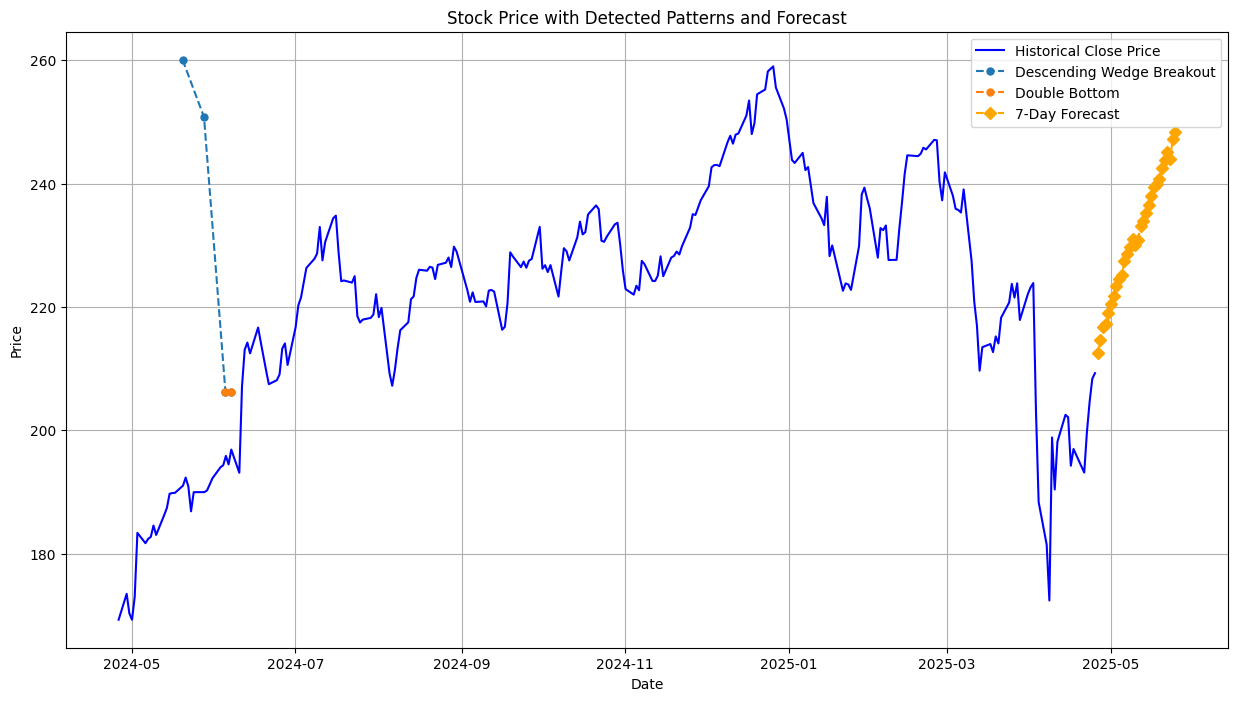

In [8]:
# 1. Imports
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient
from dotenv import load_dotenv
import os

# 2. Load environment
load_dotenv()

# 3. Connect to Mongo
client = MongoClient(os.getenv("MONGO_URI"))
db = client["PeliCanStonks"]
collection_history = db["stonk_history"]
collection_forecast = db["technical_analysis"]

# 4. Load the latest historical stock data
latest_history = collection_history.find().sort("timestamp", -1).limit(1)[0]["forecast"]
history_df = pd.DataFrame(latest_history)

# Clean and convert timestamp
history_df["timestamp"] = pd.to_datetime(history_df["timestamp"], errors="coerce")
history_df = history_df.dropna(subset=["timestamp"])

# 5. Load the latest forecast
latest_forecast_doc = collection_forecast.find().sort("timestamp", -1).limit(1)[0]
latest_forecast = latest_forecast_doc["forecast"]
weekly_forecast = latest_forecast.get("weekly_forecast", [])

# 6. Create figure
plt.figure(figsize=(15, 8))

# 7. Plot historical close prices
plt.plot(history_df["timestamp"], history_df["close"], label="Historical Close Price", color="blue")

# 8. Plot detected patterns (connect supporting points properly)
for pattern in latest_forecast.get("detected_patterns", []):
    pattern_name = pattern["pattern_name"]
    dates = []
    prices = []

    for point in pattern["supporting_points"]:
        try:
            day = pd.to_datetime(point["day"], errors="coerce")
            if point["type"] == "high":
                price = point["high"]
            elif point["type"] == "low":
                price = point["low"]
            else:
                continue

            if pd.notnull(day):
                dates.append(day)
                prices.append(price)
            else:
                print(f"⚠️ Skipping invalid date: {point['day']}")
        except Exception as e:
            print(f"⚠️ Skipping invalid point: {e}")

    if dates and prices:
        dates, prices = zip(*sorted(zip(dates, prices)))
        plt.plot(dates, prices, label=f"{pattern_name}", linestyle="--", marker="o", markersize=5)

# 9. Plot forecasted 7 days
if weekly_forecast:
    forecast_dates = pd.date_range(
        start=history_df["timestamp"].max() + pd.Timedelta(days=1),
        periods=len(weekly_forecast),
        freq="D"
    )
    forecast_close_prices = [day["close"] for day in weekly_forecast]

    plt.plot(forecast_dates, forecast_close_prices, label="7-Day Forecast", linestyle="--", color="orange", marker="D")

# 10. Final plot adjustments
plt.title("Stock Price with Detected Patterns and Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()